In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [10]:
df_wine, target = load_wine(return_X_y=True, as_frame=False)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_wine, target, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [12]:
np.set_printoptions(precision=5)
mean_vecs = []
for label in range(3):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label - 1]))

MV 0: [ 0.92587 -0.30912  0.25923 -0.79894  0.30385  0.96084  1.05152 -0.63058
  0.53539  0.22091  0.48549  0.79805  1.20171]

MV 1: [ 0.92587 -0.30912  0.25923 -0.79894  0.30385  0.96084  1.05152 -0.63058
  0.53539  0.22091  0.48549  0.79805  1.20171]

MV 2: [-0.87274 -0.38544 -0.44367  0.24807 -0.24091 -0.10587  0.01874 -0.0164
  0.10952 -0.87962  0.43924  0.27761 -0.70156]



In [13]:
d = 13 # number of features
S_W = np.zeros((d, d))

for label, mv in zip(range(4), mean_vecs):
    class_scatter = np.zeros((d, d))
    
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
        
    S_W += class_scatter
    
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))
print('Class label distribution: %s' % np.bincount(y_train))

Within-class scatter matrix: 13x13
Class label distribution: [40 49 35]


In [14]:
mean_overall = np.mean(X_train_std, axis=0)

d = 13 # number of features
S_B = np.zeros((d, d))
for i,mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [15]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [16]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

10.851109878956104
3.8430695416038536
1.0769781751085494e-15
9.389461114764586e-16
8.881784197001252e-16
4.494447585123205e-16
4.494447585123205e-16
3.412940213664047e-16
2.6402089322434e-16
2.6402089322434e-16
1.5869824704698232e-16
1.5869824704698232e-16
6.802458850329358e-17


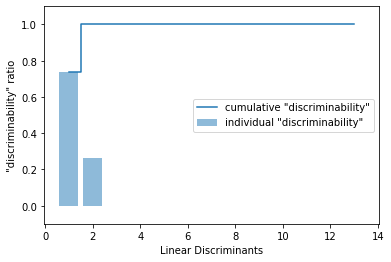

In [21]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.show()

In [26]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))

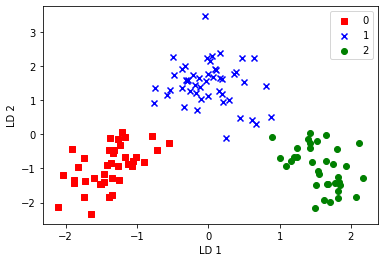

In [27]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper right')
plt.show()

# Sklearn LDA

In [36]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

In [37]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


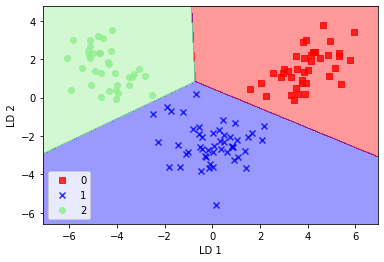

In [38]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


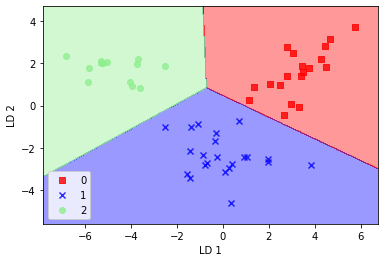

In [39]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()